In [1]:
import sys
import os

astromer_path = ".."
sys.path.append(astromer_path)

In [2]:
import pandas as pd

from ASTROMER.core.data import pretraining_records
from ASTROMER.core.multiband_astromer import get_MBAstromer

In [3]:
train_data = pretraining_records(
    "/Users/gchiong/Downloads/alcock/fold_0/alcock_500/train",
    batch_size=256,
    shuffle=True,
    max_obs=200,
    msk_frac=0.5,
    rnd_frac=0.2,
    same_frac=0.2,
)

val_data = pretraining_records(
    "/Users/gchiong/Downloads/alcock/fold_0/alcock_500/val",
    batch_size=256,
    shuffle=True,
    max_obs=200,
    msk_frac=0.5,
    rnd_frac=0.2,
    same_frac=0.2,
)

test_data = pretraining_records(
    "/Users/gchiong/Downloads/alcock/fold_0/alcock_500/test",
    batch_size=256,
    shuffle=True,
    max_obs=200,
    msk_frac=0.5,
    rnd_frac=0.2,
    same_frac=0.2,
)

label_dict = pd.read_csv("/Users/gchiong/Downloads/alcock/fold_0/alcock_500/objects.csv")["label"].to_dict()

In [4]:
train_data.take(2)

<_TakeDataset element_spec={'output': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), 'input': TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), 'times': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), 'mask_out': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), 'mask_in': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), 'length': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization


def get_mlp_backprop(num_classes, maxlen=200):
    ''' FC + ATT'''
    inputs = {
        'input': tf.keras.Input(shape=(maxlen, 1), name='input'),
        'times': tf.keras.Input(shape=(maxlen, 1), name='times'),
        'mask_in': tf.keras.Input(shape=(maxlen, 1), name='mask'),
        'length': tf.keras.Input(shape=(maxlen, 1), name='length'),
    }

    model = get_MBAstromer(["macho", "atlas"])

    reduce_mean_layer = model.get_layer('reduce_mean')
    encoder = tf.keras.Model(inputs=model.inputs, outputs=reduce_mean_layer.output)

    m = tf.cast(1.-inputs['mask_in'][...,0], tf.bool)
    x = encoder(inputs)
    x = tf.ragged.boolean_mask(x, m)
    x = tf.reduce_mean(x, 1)

    x = Dense(1024, activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name="MLP_ATT")

In [6]:
classes = len(label_dict)

In [7]:
model_MLP = get_mlp_backprop(classes)
model_MLP.summary()

Model: "MLP_ATT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 200, 1)]             0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 200)                  0         ['mask[0][0]']                
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 200)                  0         ['tf.__operators__.getitem[0][
 da)                                                                0]']                          
                                                                                            

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


estop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=50,
    mode='auto',
    restore_best_weights=True,
)

optimizer = Adam(learning_rate=5e-4)

model_MLP.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics='accuracy'
)

In [9]:
def extract_inputs_and_targets(data):
    inputs = {
        'input': data['input'],
        'times': data['times'],
        'mask_in': data['mask_in'],
        'length': data['length'],
    }
    targets = data['label']
    return inputs, targets

In [10]:
train_data_prepared = train_data.map(extract_inputs_and_targets)
val_data_prepared = val_data.map(extract_inputs_and_targets)

In [11]:
hist = model_MLP.fit(
    train_data_prepared, 
    epochs=25,
    validation_data=val_data_prepared,
    callbacks=[estop],
    verbose=2,
)

Epoch 1/25
38/38 - 33s - loss: 1.7174 - accuracy: 0.3488 - val_loss: 1.8683 - val_accuracy: 0.1981 - 33s/epoch - 873ms/step
Epoch 2/25
38/38 - 31s - loss: 1.4663 - accuracy: 0.4180 - val_loss: 1.8534 - val_accuracy: 0.2045 - 31s/epoch - 804ms/step
Epoch 3/25
38/38 - 31s - loss: 1.4010 - accuracy: 0.4497 - val_loss: 1.7720 - val_accuracy: 0.2057 - 31s/epoch - 804ms/step
Epoch 4/25
38/38 - 31s - loss: 1.3555 - accuracy: 0.4673 - val_loss: 1.7687 - val_accuracy: 0.2129 - 31s/epoch - 804ms/step
Epoch 5/25
38/38 - 31s - loss: 1.3236 - accuracy: 0.4847 - val_loss: 1.7679 - val_accuracy: 0.3050 - 31s/epoch - 810ms/step
Epoch 6/25
38/38 - 31s - loss: 1.2955 - accuracy: 0.4955 - val_loss: 1.7198 - val_accuracy: 0.3308 - 31s/epoch - 807ms/step
Epoch 7/25
38/38 - 31s - loss: 1.2679 - accuracy: 0.5072 - val_loss: 1.9570 - val_accuracy: 0.3118 - 31s/epoch - 811ms/step
Epoch 8/25
38/38 - 31s - loss: 1.2560 - accuracy: 0.5101 - val_loss: 1.6070 - val_accuracy: 0.3325 - 31s/epoch - 809ms/step
Epoch 9/

Matplotlib is building the font cache; this may take a moment.


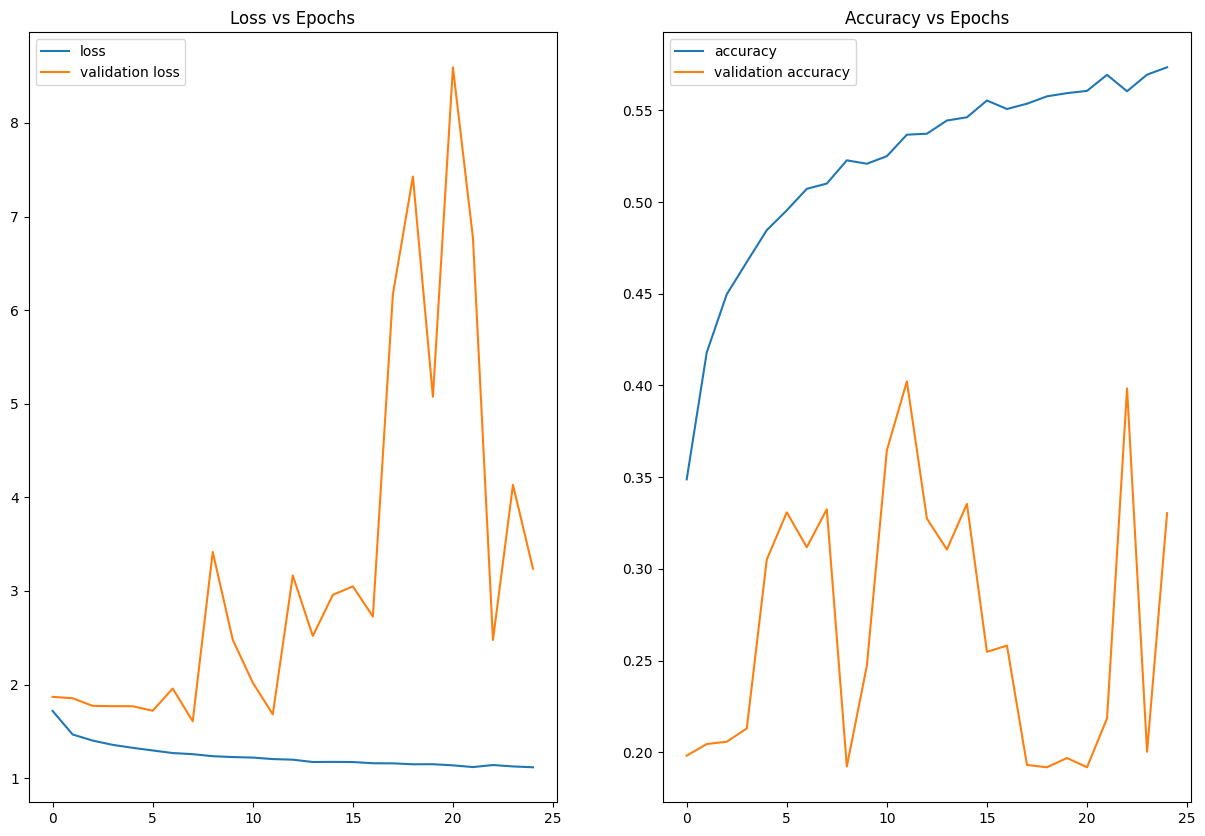

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
epochs = hist.epoch
ax = fig.add_subplot(1,2,1)
ax.plot(epochs,hist.history['loss'],label = 'loss')
ax.plot(epochs,hist.history['val_loss'],label = 'validation loss')
ax.set_title("Loss vs Epochs")
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(epochs,hist.history['accuracy'],label = 'accuracy')
ax.plot(epochs,hist.history['val_accuracy'],label = 'validation accuracy')
ax.set_title("Accuracy vs Epochs")
ax.legend();